In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(tidyr)
        library(ggplot2)        
        library(scales)
        library(patchwork) 
        library(purrr)
        library(dplyr)
        library(GGally)
        library(ISLR)
    })
})

In [2]:
# Size and general style set up
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

# Load Data
player_data <- read_csv("https://raw.githubusercontent.com/FabianoGLentini/player-subscription-ml/refs/heads/main/data/players.csv")


# Data Science Project: Project Final Report


## Introduction: 
For this project, we are analyzing data collected by researchers in Computer Science at UBC. They have set up a MineCraft server that allows them to record consenting players’ behaviour and characteristics for study. In particular, we want to answer the question: **What players' `Age`, `gender`, and `played_hours` can best predict whether they would `subscribe` to a gaming newsletter, and how does it differ from players `experience`?** In this project, we will focus on the `players.csv` dataset, as it is of most use to us to answer our question. The `players.csv` set contains 196 observations and 7 variables. This data is already in its tidy form because every column is a single variable, every row is a single observation, and every cell is a single value.  We can see that there are three types of variables here: character, logical, and double. 

**Character Variables:**

`hashedEmail` (email of player that has been converted into a unique string of characters, for privacy)

`name` (first name of player)

`gender` (gender of player)

`experience` (skill level of player)

**Double Variables:**

`played_hours` (number of hours spent on the game by each player)

`Age` (age in years of each player)

**Logical variable:**

`subscribe` (whether or not the player is subscribed to the game newsletter) 

For our question, we want to know if a player's age, gender, and amount of played hours can determine if they will subscribe to the game newsletter or not. We chose these three predictor variables because they are all characteristics of each individual player that can allow us to group them and determine which type of player is most likely to subscribe. Additionally, we want to determine if any difference in experience across players will be a factor in whether or not a player is subscribed.

A potential issue with this data under the `played_hours` variable, we can see that many players have 0 hours played. This could cause weird results when we begin to wrangle. Furthermore, some values under the `gender` variable contain very little sample sizes, making it hard to scale these categories. 

## Methods & Results:

### Set up and intro to data: "TODO should rename later." 

In [3]:
# Wrangle data
#TODO will need additional wranggling due to poor or few varied sample categories
player_df <- player_data |> # TODO must consider reworking a joining of some labels in gender etc due to low representaions
            select( subscribe, gender, played_hours, experience, Age) |>
            drop_na() |>
            mutate(
                subscribe = as_factor(subscribe),  # lgl -> fct for analysis and modeling
                gender = as_factor(gender),        # chr -> fct for analysis and modeling
                played = factor(as.logical(played_hours)), # TODO may not use 
                experience = as_factor(experience) # chr -> fct for analysis and modeling
            ) |>
             mutate(gender = fct_recode(gender, # Aggregate some of the gender to balance out count and avoid missclassification due to underepresented categories
                                    "Non-binary/Other" = "Agender",
                                    "Non-binary/Other" = "Non-binary",
                                     "Non-binary/Other" = "Two-Spirited",
                                    "Non-binary/Other" = "Other"
                                      ))
 # Removed row with NA values, as it may distort the model      

# TODO FABIO check if player_hours should adjust to use a binary outcome, 
# either played or didn't play at all, or if any of the predictor should be removed.


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `gender = fct_recode(...)`.
Caused by warning:
! Unknown levels in `f`: Other”


### Training and Analysis:

In [4]:
# head(player_df) # TODO DELETE tmp  for set up 

In [5]:
# SPLIT/SCALE DATA
set.seed(2025) # Don't change
# Prep for modelling
ply_df <- select(player_df, Age, subscribe, gender, played_hours)  # Exclude row_id & experience for modeling purposes

# Split step
player_split <- initial_split(ply_df, prop = 0.70, strata = subscribe) 
player_train <- training(player_split)
player_test <- testing(player_split)

In [6]:
#TODO FABIO write up split/scale/recipe step reasoning
# 'initial split' Use Strata sub to balance the outcome for the bool prediction to avoid 
# imbalance in our test and train data split

# ... why use 75 25 split instead of 70/30 etc?

# ~ maybe explain why start with all predictors

In [7]:
# Recipes:
# Scale/Recipe

# Note: A = Age, G = gender and H = played_hours
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())
# # Recipe 02:
# Age + played_hours
rc_AH <- recipe(subscribe ~ Age + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 03:
# Age + gender 
rc_AG <- recipe(subscribe ~ Age + gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 04:
# gender + played_hours
rc_GH <- recipe(subscribe ~ gender + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 05:
# Age
rc_A <- recipe(subscribe ~ Age, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 06:
# gender
rc_G <- recipe(subscribe ~ gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 07:
# played_hours
rc_H <- recipe(subscribe ~ played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())



In [8]:
#TODO FABIO breackdown hypothesis for each recipe variation ...?

In [9]:
# Spec set up
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#TODO FABIO ... search refractor options to reduce code clutter
# Check mean and standard error through collect_metrics


In [10]:
# TODO FABIO confirm that not having set.seed here is fine as long as set.seed above code cell goes first
# K-fold cross-validation
set.seed(1234) # Don't change
kfolds <- vfold_cv(player_train, v = 7, strata = subscribe)
k_vals = tibble(neighbors = seq(from = 1, to = 5, by = 1))


In [11]:
# TODO FABIO ~ write up spec use and impl of vfold..?

In [12]:
#TODO FABIO write reasonin + graph to show fold outcome
#Note the reason of using 10 10-fold is due to the small size data,
#hence it will improve the estimate and 

In [13]:
# Simplifying multi-model testing: https://www.youtube.com/watch?v=YZqbOATpjM4&t=139s
# Workflow Step
workflow_set <- workflow_set(
    preproc = list(
        AGH = rc_AGH,
        AH = rc_AH,
        AG = rc_AG,
        GH = rc_GH,
        A = rc_A,
        G = rc_G,
        H = rc_H
    ),
    models = list(knn_tune),
    cross = TRUE
)

# Tune workflow
# set.seed(22)

knn_tuned_set <- workflow_map(
    workflow_set,
    "tune_grid",
    resamples = kfolds,
    grid = k_vals,
    seed = 22
)


In [14]:
#TODO FABIO write workflow step use case/what it functionally is doing 

In [15]:

options(repr.plot.width = 15, repr.plot.height = 5)
# Get metrics all in one
all_metrics_collected <- workflow_map(
    knn_tuned_set,
    metrics = metric_set(accuracy, recall, precision)
) 

all_metrics_collected_res <- collect_metrics(all_metrics_collected)

→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 5 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x1





In [16]:
# res_All_met_tuned

In [17]:
# all_metrics_collected_res
#TODO TMP trying to regain neighbours
res_All_met_tuned <- all_metrics_collected |>
            rowwise() |>
            mutate(metrics = list(collect_metrics(result)),
                  wflow_id = fct_recode(wflow_id,
                      "Age, gender and played hours" = "AGH_nearest_neighbor",
                      "Gender and played hours" = "GH_nearest_neighbor",
                      "Gender" = "G_nearest_neighbor",
                      "Age and gender" = "AG_nearest_neighbor",
                      "Age and played hours" = "AH_nearest_neighbor",
                      "Age" = "A_nearest_neighbor",
                      "Played hours" = "H_nearest_neighbor",
                  )) |>
            unnest(metrics) |>
            select(wflow_id, .metric, mean, neighbors, std_err) |>
            arrange(desc(mean))
# ADD RANKING
ranked_met <- res_All_met_tuned |>
            mutate(rank = seq(1, nrow(res_All_met_tuned), 1))
# ranked_met
# Visualize result
options(repr.plot.width = 8, repr.plot.height = 5)

plot_met_tmp <- ggplot(ranked_met, aes(x = rank, y = mean, color = wflow_id)) +
                geom_point() +
                 # geom_errorbar(aes(ymin = mean - std_err, ymax = mean + std_err), width=.2, #TODO TMP test to see if use line but std_err may not be correct
                 # position = position_dodge(0.05)) + 
                ylim(c(0,1)) + 
                labs(x = "Ranke by metric mean", y = "Metric mean percentage", color = "Predictor Combinations") 

# plot_met_tmp


Warning message:
“There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `wflow_id = fct_recode(...)`.
ℹ In row 1.
Caused by warning:
! Unknown levels in `f`: GH_nearest_neighbor, G_nearest_neighbor, AG_nearest_neighbor, AH_nearest_neighbor, A_nearest_neighbor, H_nearest_neighbor
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.”


In [18]:
# METRICS set up Graphs
# Accuracy
acc_met <- res_All_met_tuned |>
            filter(.metric ==  "accuracy")
acc_met_rank <- mutate(acc_met, rank = seq(1, nrow(acc_met), 1))
acc_met_plot <- plot_met_tmp %+% acc_met_rank +
                guides(color = "none") + 
                ggtitle("Ranked by Accuracy Mean") 

                


# Precision
prec_met <- res_All_met_tuned |>
            filter(.metric ==  "precision")
prec_met_rank <- mutate(prec_met, rank = seq(1, nrow(prec_met), 1))
prec_met_plot <- plot_met_tmp %+% prec_met_rank +
                guides(color = "none") + 
                ggtitle("Ranked by Precision Mean") 
                



# Recall
rec_met <- res_All_met_tuned |>
            filter(.metric ==  "recall")
rec_met_rank <- mutate(rec_met, rank = seq(1, nrow(rec_met), 1))
rec_met_plot <- plot_met_tmp %+% rec_met_rank +
                ggtitle("Ranked by Recall Mean")


In [19]:
#TODO conf amat graph of each category ???


In [20]:
# mutate(rec_met_rank, rec_met = mean )
# mutate(prec_met_rank, rec_met = mean)
# mutate(acc_met_rank, rec_met = mean )
# res_All_met_tuned


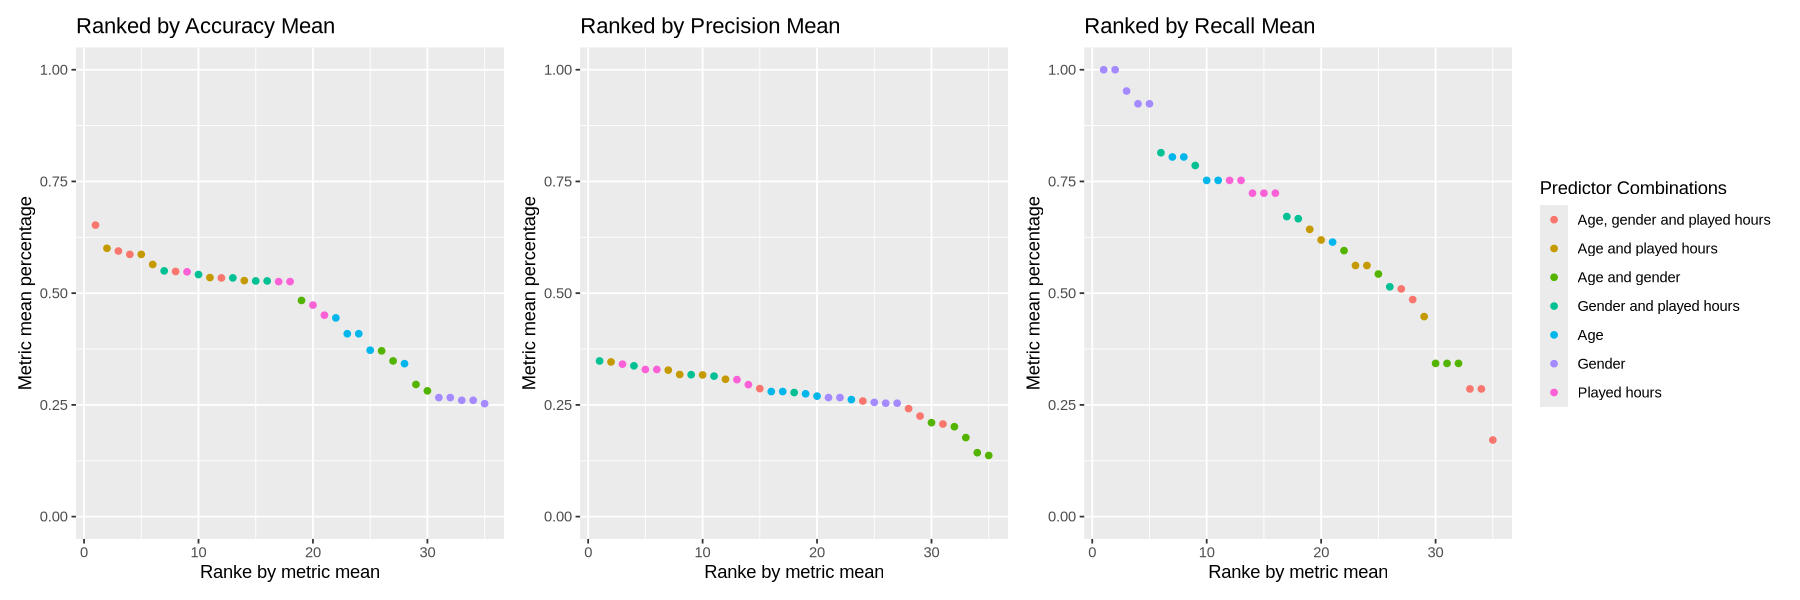

In [21]:
# All results side by side
options(repr.plot.width = 15, repr.plot.height = 5)
#TODO fabio add std_err line but also combine color and shape legend
# side_by_side_met
acc_met_plot + prec_met_plot + rec_met_plot

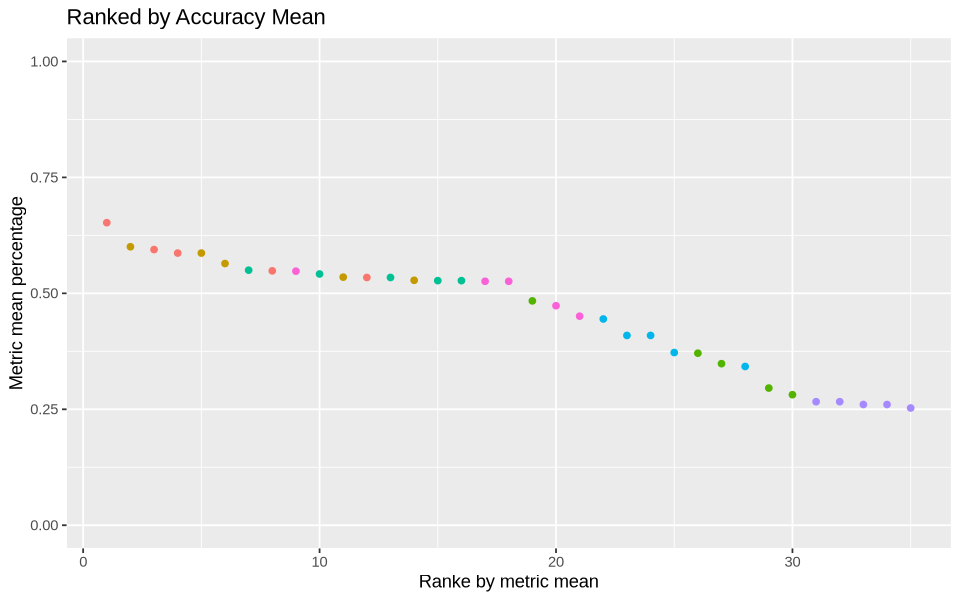

In [22]:
options(repr.plot.width = 8, repr.plot.height = 5)
# Accuracy tuned metric plot
acc_met_plot

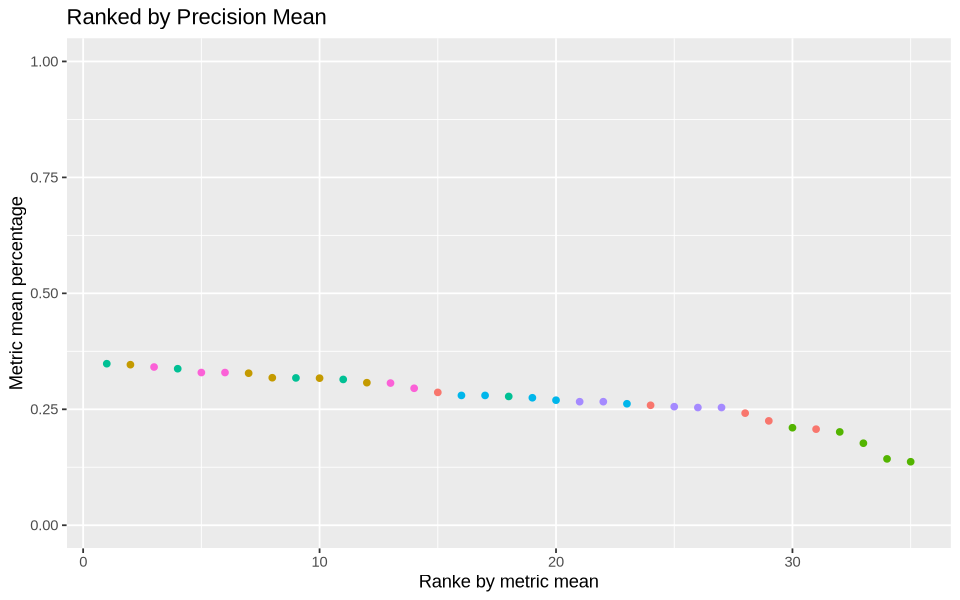

In [23]:
options(repr.plot.width = 8, repr.plot.height = 5)
# Accuracy tuned metric prec
prec_met_plot

In [24]:

#TODO write about the result prec

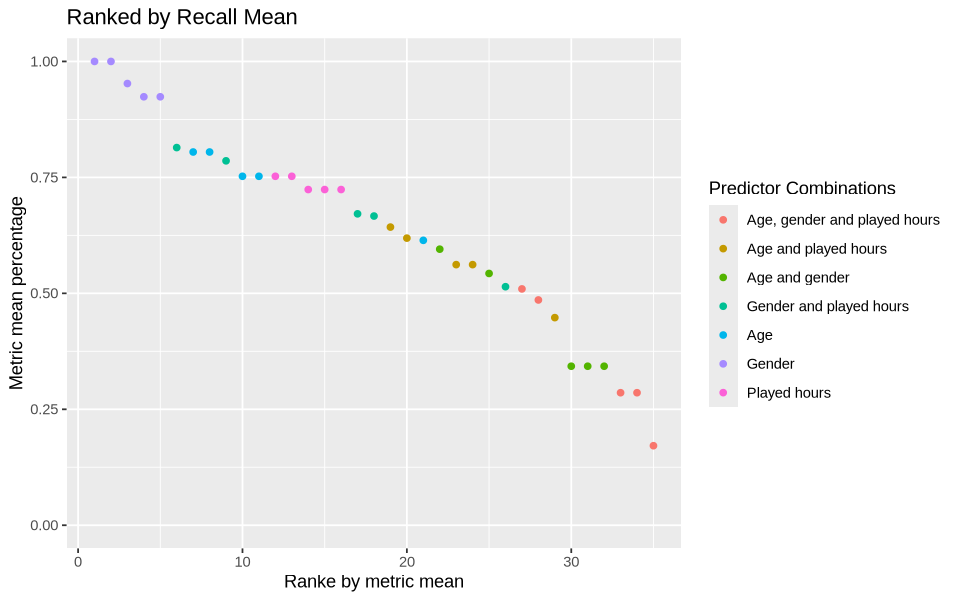

In [25]:
options(repr.plot.width = 8, repr.plot.height = 5)
# Accuracy tuned metric rec
rec_met_plot

In [26]:
#TODO write about the result rec

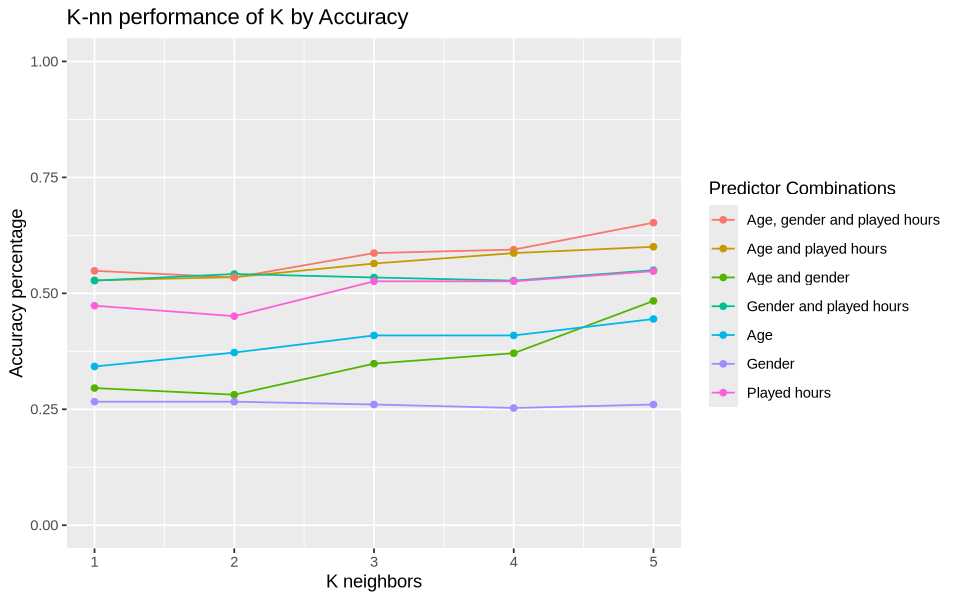

In [27]:
options(repr.plot.width = 8, repr.plot.height = 5)
# LINE Graph showing k performance for each recipe
overlapped_line_acc <- ggplot(acc_met, aes(x = neighbors, y = mean, color = wflow_id)) +
                        geom_line() +
                        geom_point() + 
                        ylim(c(0, 1)) + 
                        scale_x_continuous(breaks = seq(0,5,1)) +
                        labs(
                            x = "K neighbors", 
                            y = "Accuracy percentage",  
                            color = "Predictor Combinations",
                        )  +
                        ggtitle("K-nn performance of K by Accuracy")
                        

overlapped_line_acc

In [28]:
#TODO FABIO discuss on concerns for high k doing so well, should concider reducing k for some options maybe?
# Accuracy

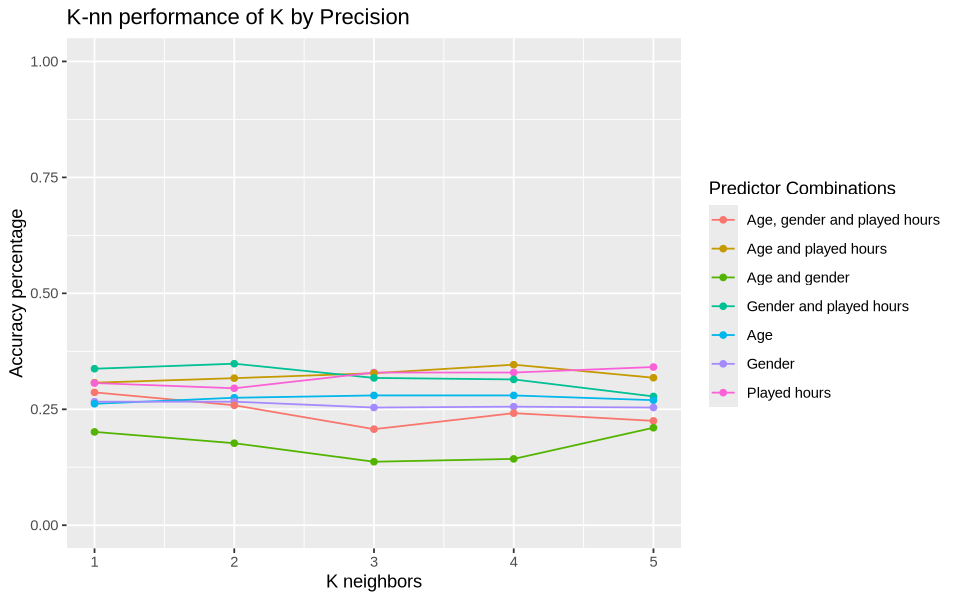

In [29]:
options(repr.plot.width = 8, repr.plot.height = 5)
# LINE Graph showing k performance for each recipe Using precision
overlapped_line_prec <- overlapped_line_acc %+% prec_met +
                        ggtitle("K-nn performance of K by Precision")
overlapped_line_prec

In [30]:
#TODO FABIO discuss on concerns for high k doing so well, should concider reducing k for some options maybe?
# Precission

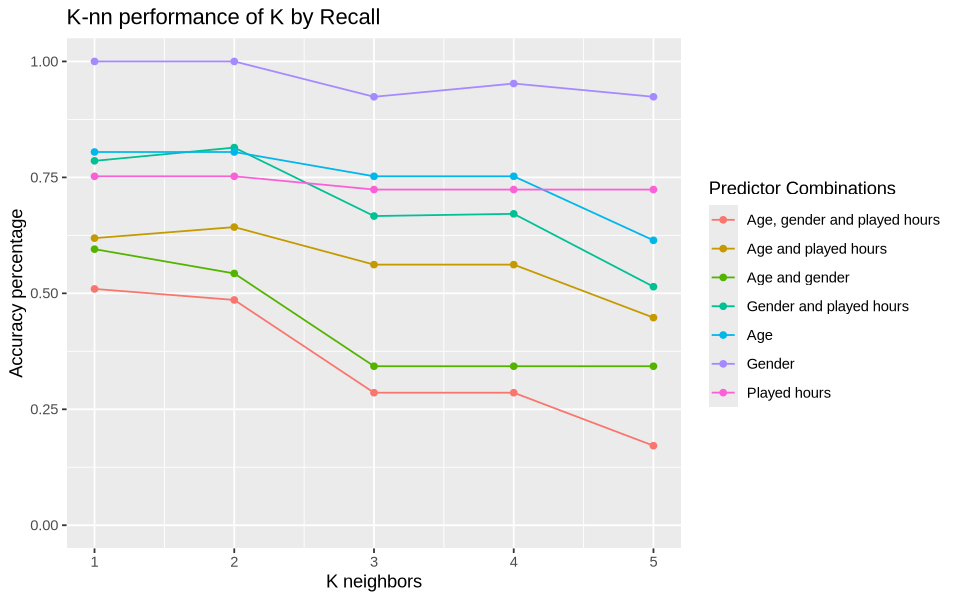

In [31]:
options(repr.plot.width = 8, repr.plot.height = 5)
# LINE Graph showing k performance for each recipe Using precision
overlapped_line_rec <- overlapped_line_acc %+% rec_met +
                        ggtitle("K-nn performance of K by Recall")
overlapped_line_rec

In [32]:
#TODO FABIO discuss on concerns for high k doing so well, should concider reducing k for some options maybe?
# Recall

In [33]:
# SELECT FINAL MODEL AND TRAIN 
set.seed(22)
#TMP DELETE
# player_test
# player_train

# Model Age + played_hours with k = 5 recipe(rc_AH)
final_md_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

final_md_fit <- workflow() |>
            add_recipe(rc_AGH) |>
            add_model(final_md_spec) |>
            fit(player_train)
# final_md_fit


########
final_md_pred <- predict(final_md_fit, player_test) |>
                bind_cols(player_test)
# final_md_pred

final_md_met <- final_md_pred |>
                metrics(truth = subscribe, estimate = .pred_class)
final_md_met
# final_md_met
final_md_mat <- conf_mat(final_md_pred, truth = subscribe, estimate = .pred_class)
final_md_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136
kap,binary,0.2224053


          Truth
Prediction FALSE TRUE
     FALSE     5    5
     TRUE     11   38

### Player Type Exploration: "TODO may need renaming"

## Discussion:

### Reference 

##### Data Science programming techniques and approaches:
- **Clustering prediction:** https://www.youtube.com/watch?v=z57i2GVcdww
- **Simplifying multi-model set up + testing:** https://www.youtube.com/watch?v=YZqbOATpjM4
- **Tuning and comparing models using Workflowse:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models.html
- **Useful example of report/tutorial for tidy models:** https://optimumsportsperformance.com/blog/k-nearest-neighbor-tidymodels-tutorial/
- **Additional breakdown on workflow_set usage:** https://www.youtube.com/watch?v=R95lWUDtL5A
- **Workflow_set documentation on results:** https://workflowsets.tidymodels.org/reference/collect_metrics.workflow_set
- **Workflow_set tunning and comparing documentation:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models
- **Plot ggpair examples breakdown for reference:** https://r-charts.com/correlation/ggpairs/
- **margin of error plot template models:** https://www.sthda.com/english/wiki/ggplot2-error-bars-quick-start-guide-r-software-and-data-visualization

In [34]:
#TODO tmp info grounds

?guides

guides {ggplot2},R Documentation
...,"List of scale name-guide pairs. The guide can either be a string (i.e. ""colorbar"" or ""legend""), or a call to a guide function (i.e. guide_colourbar() or guide_legend()) specifying additional arguments."
